# Test clustering using PCL Region Growing

In [1]:
%matplotlib widget
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib import cm
import math
import time

import pclpy
from pclpy import pcl

In [2]:
pcdfile = os.path.join(os.getcwd(),'..', 'data', 'airsim', 'blocks_100.pcd')

pc = pcl.PointCloud.PointXYZ()
reader = pcl.io.PCDReader()
reader.read(pcdfile, pc)

N_PTS = len(pc.xyz)

Compute normals

In [3]:
rg = pcl.segmentation.RegionGrowing.PointXYZ_Normal()

rg.setInputCloud(pc)
normals_estimation = pcl.features.NormalEstimationOMP.PointXYZ_Normal()
normals_estimation.setInputCloud(pc)
normals = pcl.PointCloud.Normal()
normals_estimation.setRadiusSearch(5.0)
start_time = time.time()
normals_estimation.compute(normals)
print("elapsed time: ", time.time() - start_time)

elapsed time:  0.04290509223937988


In [4]:
normals_arr = np.empty((N_PTS, 3))
for i in range(N_PTS):
    normals_arr[i,0] = normals.points[i].normal_x
    normals_arr[i,1] = normals.points[i].normal_y
    normals_arr[i,2] = normals.points[i].normal_z

Show normals

Text(0.5, 0.5, 'Y')

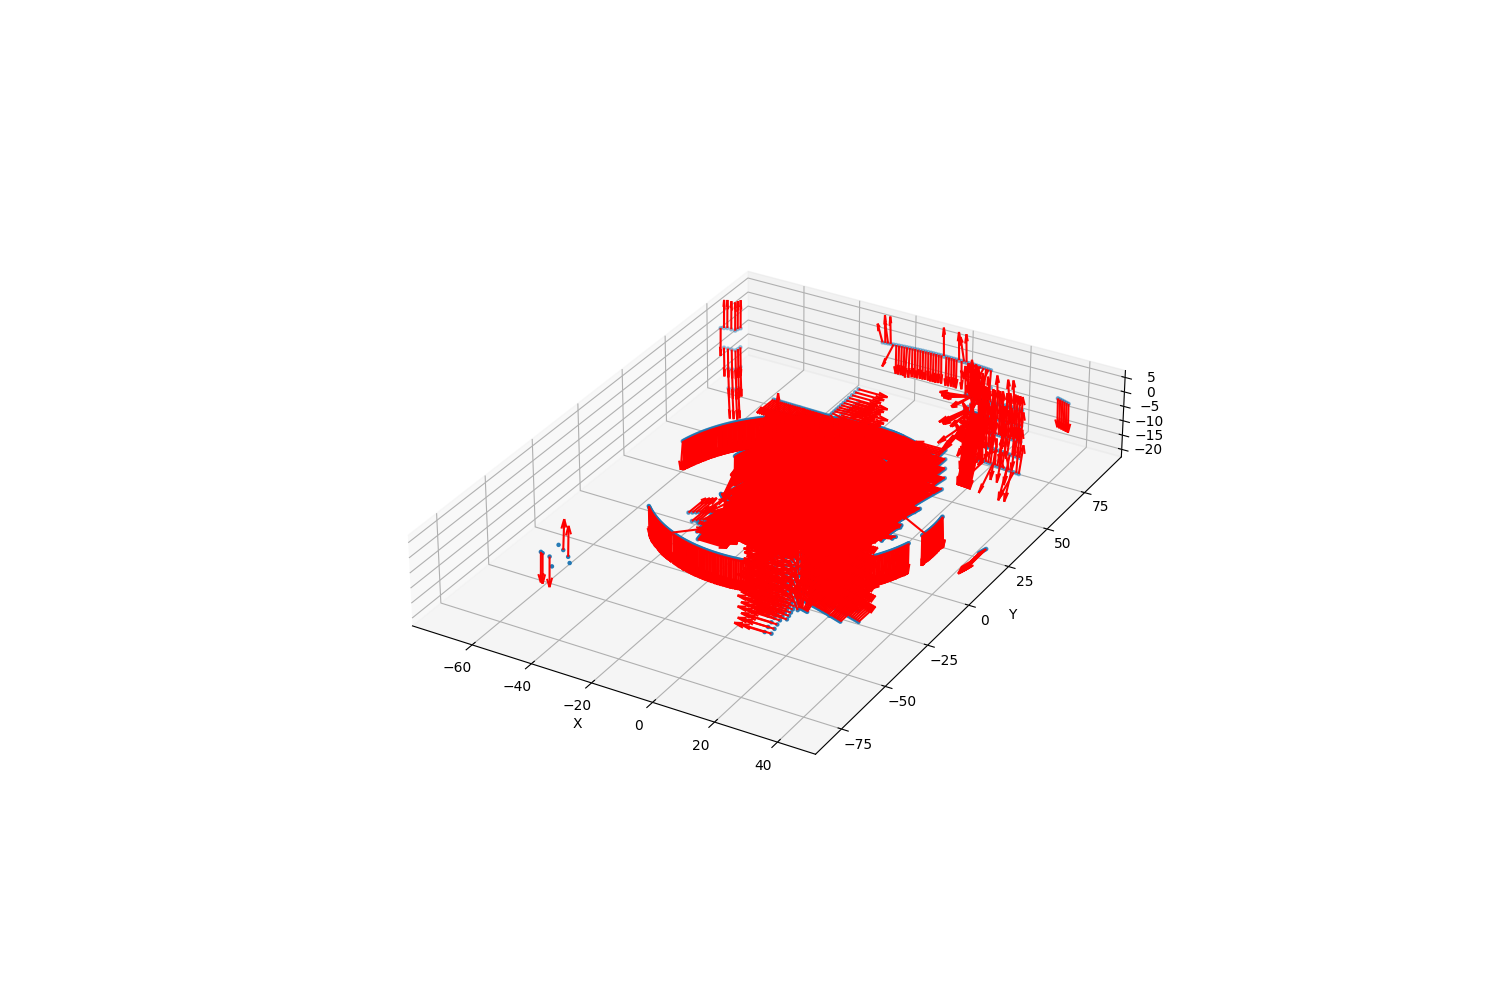

In [39]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1, 1, 1, projection='3d')

ax.scatter3D(pc.xyz[:,0], pc.xyz[:,1], pc.xyz[:,2], marker='.')  
n_viz = 10 * normals_arr  # For quiver visualization
ax.quiver(pc.xyz[:,0], pc.xyz[:,1], pc.xyz[:,2], n_viz[:,0], n_viz[:,1], n_viz[:,2], color='r')

ax.set_box_aspect((np.ptp(pc.xyz[:,0]), np.ptp(pc.xyz[:,1]), np.ptp(pc.xyz[:,2])))
ax.set_xlabel("X")
ax.set_ylabel("Y")

Region Growing

In [5]:
rg.setInputNormals(normals)
rg.setMaxClusterSize(1000000)
rg.setMinClusterSize(10)
rg.setNumberOfNeighbours(30)
rg.setSmoothnessThreshold(5 / 180 * math.pi)
rg.setCurvatureThreshold(5)
rg.setResidualThreshold(1)
start_time = time.time()
clusters = pcl.vectors.PointIndices()
rg.extract(clusters)
print("Elapsed time: ", time.time() - start_time)
print("Number of clusters: ", len(clusters))

Elapsed time:  0.032434940338134766
Number of clusters:  23


Plot clusters

Text(0.5, 0.5, 'Y')

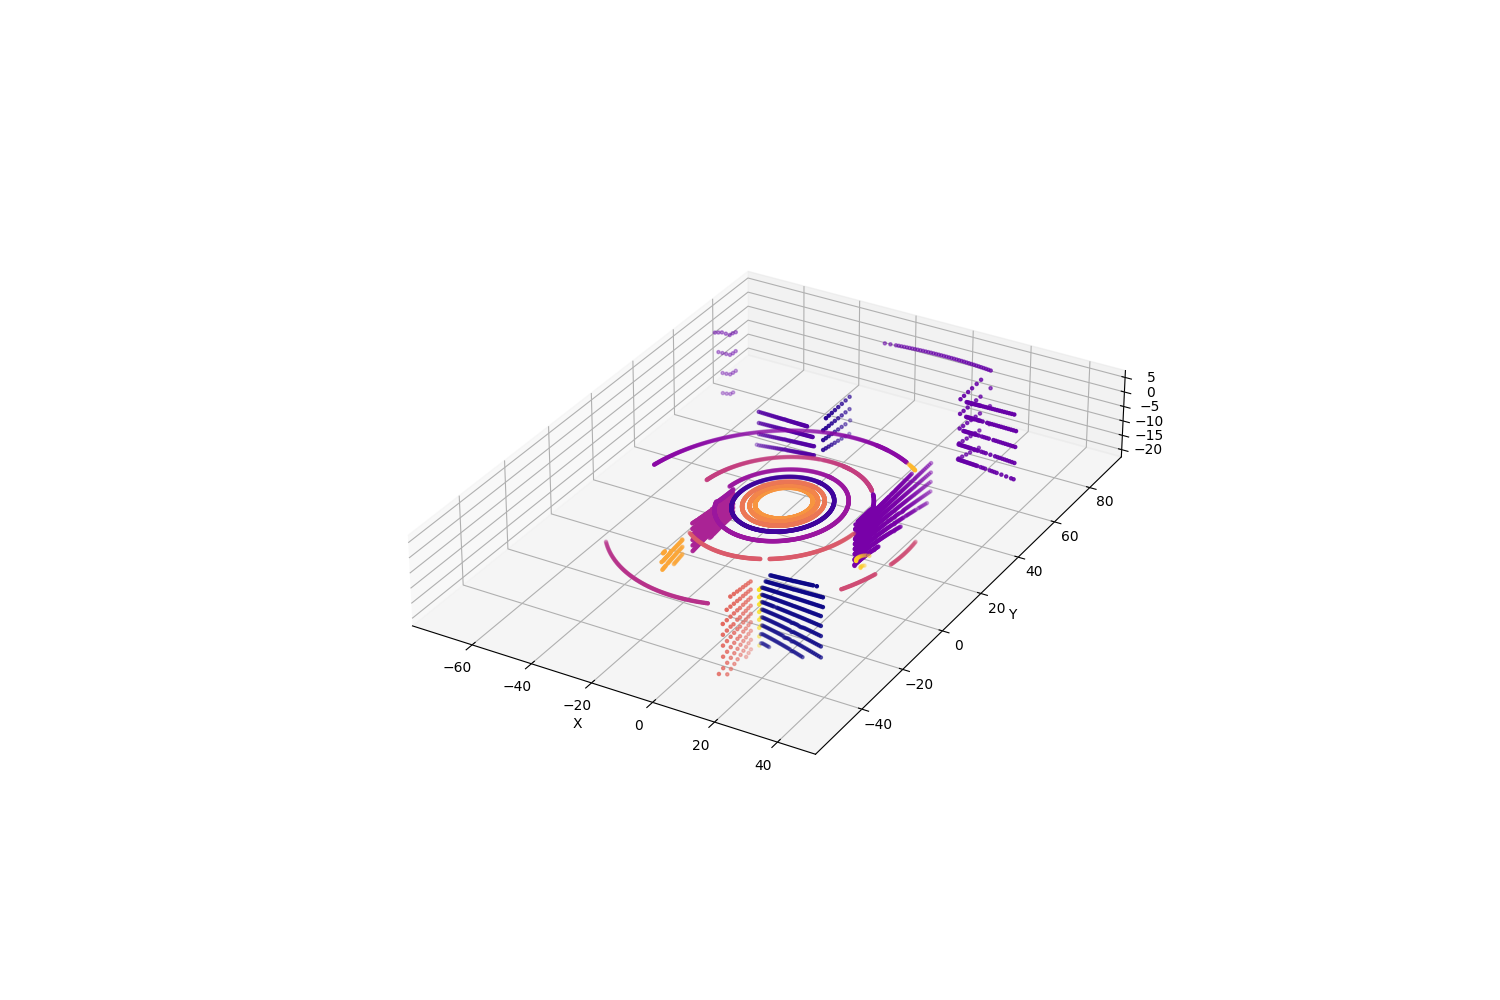

In [8]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1, 1, 1, projection='3d')

cmap = cm.get_cmap('plasma')
cmap_idxs = int(len(cmap.colors) / len(clusters)) * np.arange(len(clusters))
colors = np.asarray(cmap.colors)[cmap_idxs,:]
for i, c in enumerate(clusters):
    idx = c.indices
    ax.scatter3D(pc.xyz[idx,0], pc.xyz[idx,1], pc.xyz[idx,2], color=colors[i,:], marker='.')  
ax.set_box_aspect((np.ptp(pc.xyz[:,0]), np.ptp(pc.xyz[:,1]), np.ptp(pc.xyz[:,2])))
ax.set_xlabel("X")
ax.set_ylabel("Y")

Test plane extraction with these clusters

In [6]:
from planeslam.extraction import scan_from_pcl_clusters
from planeslam.scanrep import ScanRep

vertices, faces, normals = scan_from_pcl_clusters(pc.xyz, clusters, normals_arr)
scan = ScanRep(vertices, faces, normals)

Text(0.5, 0.5, 'Y')

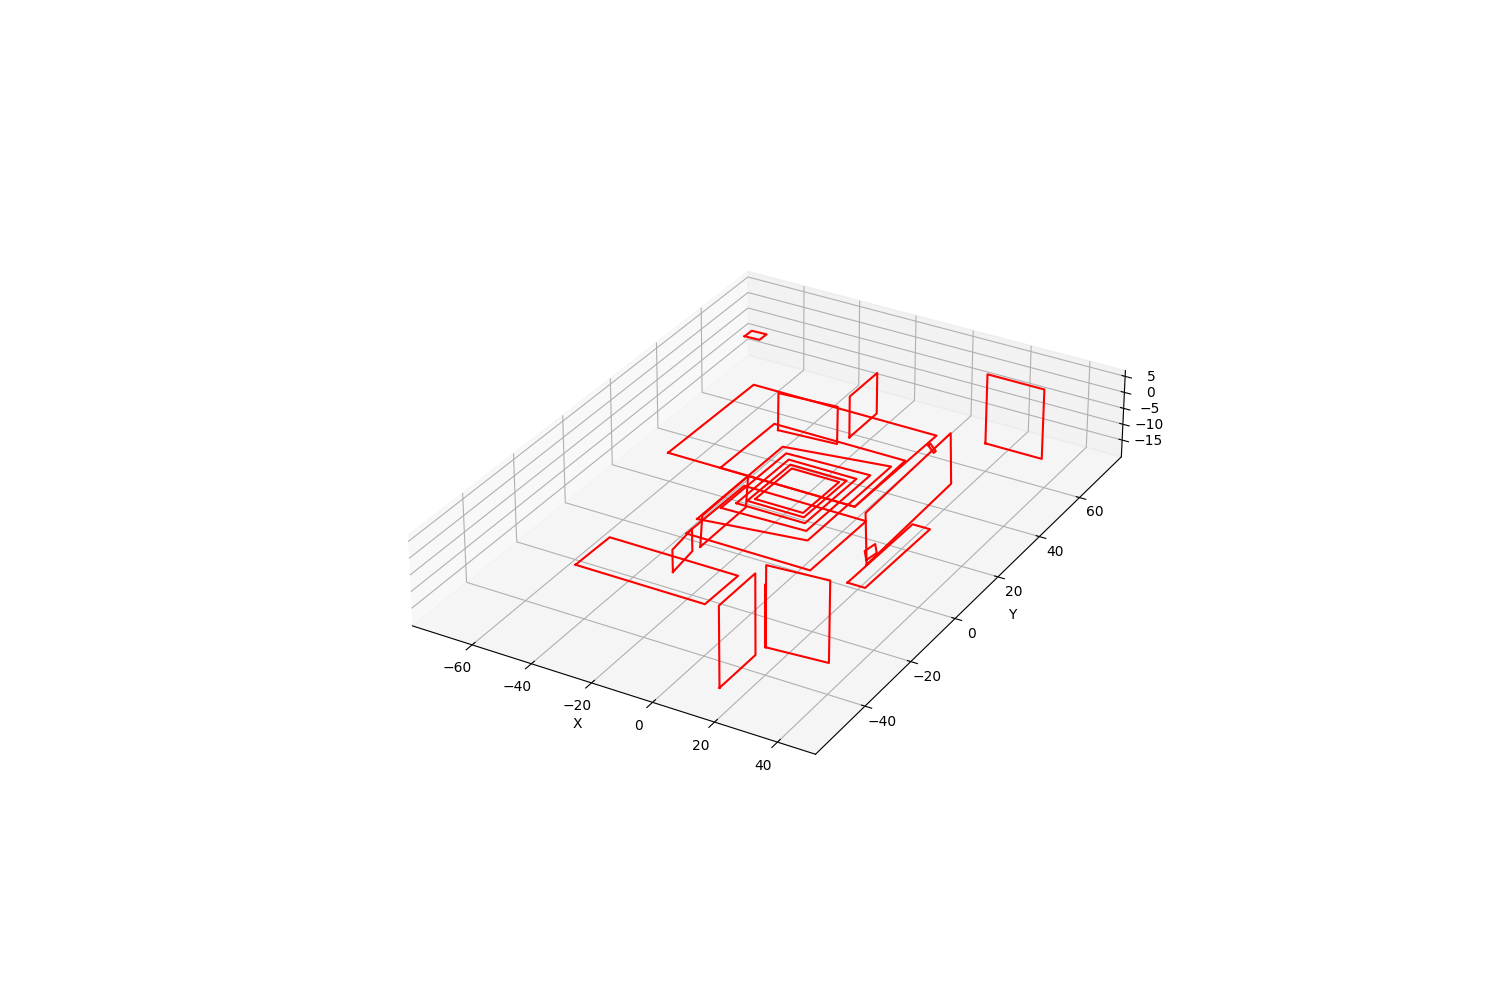

In [7]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1, 1, 1, projection='3d')

scan.plot(ax, color='r')

ax.set_box_aspect((np.ptp(pc.xyz[:,0]), np.ptp(pc.xyz[:,1]), np.ptp(pc.xyz[:,2])))
ax.set_xlabel("X")
ax.set_ylabel("Y")